In [1]:
# Special functions and optimizations
from scipy.special import gamma, kv  # Bessel function and gamma function
from scipy.stats import multivariate_normal  # Simulation
from scipy.optimize import minimize
from scipy.spatial.distance import cdist  # For space and time distance
from scipy.spatial import distance  # Find closest spatial point
from scipy.optimize import differential_evolution

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import torch
# Type hints
from typing import Callable, Union, Tuple

import os
# Add your custom path

import sys
mac_gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
sys.path.append(mac_gems_tco_path)

# Custom imports
from GEMS_TCO import orbitmap 
from GEMS_TCO import kernels 
from GEMS_TCO import evaluate
from GEMS_TCO import load_data
from GEMS_TCO import configuration as config

import pickle
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform
import pandas as pd

import matplotlib.transforms as transforms

from pathlib import Path
import json
from json import JSONEncoder

# Summary

We will explore data on an hourly scale. ```The cyclic pattern``` shown in the ```semivariograms``` indicates that we should fit the data with a model that can explain this cyclic pattern.

Secondly, ```asymmetric cross-variograms``` on some days imply that there is ```space and time interaction```, hence we should consider a non-separable model.

Lastly, ```latitude-sliced``` data shows ```spatial non-stationarity```. I plan to ```detrend for 5x10 spatial points``` in the N5N10 E110E120 region.

## Quick load empirical semiovariograms from Amarel

In [2]:
input_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/GEMS_TCO_EDA/outputs"
input_filename = "empirical_n135_45_sem_20000_july24.pkl"
    
input_filepath = os.path.join(input_path, input_filename)
# Load pickle
with open(input_filepath, 'rb') as pickle_file:
    d135_45_20000= pickle.load(pickle_file)


input_filename = "empirical_n45_135_sem_20000_july24.pkl"
    
input_filepath = os.path.join(input_path, input_filename)
# Load pickle
with open(input_filepath, 'rb') as pickle_file:
    dn45_n135_20000= pickle.load(pickle_file)


input_filename = "empirical_lat_sem_20000_july24.pkl"
    
input_filepath = os.path.join(input_path, input_filename)
# Load pickle
with open(input_filepath, 'rb') as pickle_file:
    d_lat_20000= pickle.load(pickle_file)


input_filename = "empirical_lon_sem_20000_july24.pkl"
    
input_filepath = os.path.join(input_path, input_filename)
# Load pickle
with open(input_filepath, 'rb') as pickle_file:
    d_lon_20000= pickle.load(pickle_file)



# load estimates

In [3]:

data_load_instance = load_data(config.mac_data_load_path)
df = data_load_instance.read_pickle(config.mac_estimates_day_path,config.mac_full_day_v05_pickle)
df.head(5)

,sigmasq,range_lat,range_lon,advec_lat,advec_lon,beta,nugget,loss
2024-07-01,24.793444,1.584529,1.718248,0.009089,-0.107299,0.131038,2.717239,14068.529297
2024-07-02,24.424301,1.997055,1.942683,0.043588,-0.072679,0.137124,1.513148,12357.715820
2024-07-03,26.009497,1.215236,1.558868,0.023392,-0.150548,0.199850,2.890678,14948.140625
2024-07-04,24.701347,1.612308,1.822960,-0.164069,-0.237443,0.131595,3.636499,14786.204102
2024-07-05,22.598671,2.901185,3.722327,-0.011729,-0.152072,0.072866,2.397249,12096.261719


# Empirical and theoretical directional semivariograms

# smooth 0.5

In [26]:
df_full_v05

,sigma,range_lat,range_lon,advec_lat,advec_lon,beta,nugget,loss
2024-07-01,25.764724,1.650104,1.800703,0.008788,-0.108062,0.125944,2.735307,14067.368875
2024-07-02,25.362643,2.034479,1.976054,0.043489,-0.072900,0.134146,1.479743,12356.720026
2024-07-03,26.984793,1.257040,1.612315,0.023428,-0.150636,0.193000,2.881458,14946.559828
2024-07-04,24.734497,1.631283,1.847290,-0.151081,-0.210950,0.111696,3.756732,14772.307547
2024-07-05,23.192261,3.152247,4.097375,-0.012425,-0.153744,0.067623,2.459332,12095.387668
2024-07-06,26.563257,1.761816,2.334209,0.017609,-0.158134,0.095226,3.844847,14689.017576
2024-07-07,27.009814,1.303389,2.929847,0.054774,-0.343911,0.099440,4.590658,15340.563294
2024-07-08,27.021372,1.033360,1.693576,-0.019882,-0.411843,0.157994,2.760451,14854.715879
2024-07-09,25.004042,1.428789,2.446494,0.021507,-0.220709,0.137669,1.666619,12666.084225
2024-07-10,26.734822,1.442653,2.444454,0.026680,-0.077261,0.145301,3.819127,14986.729006


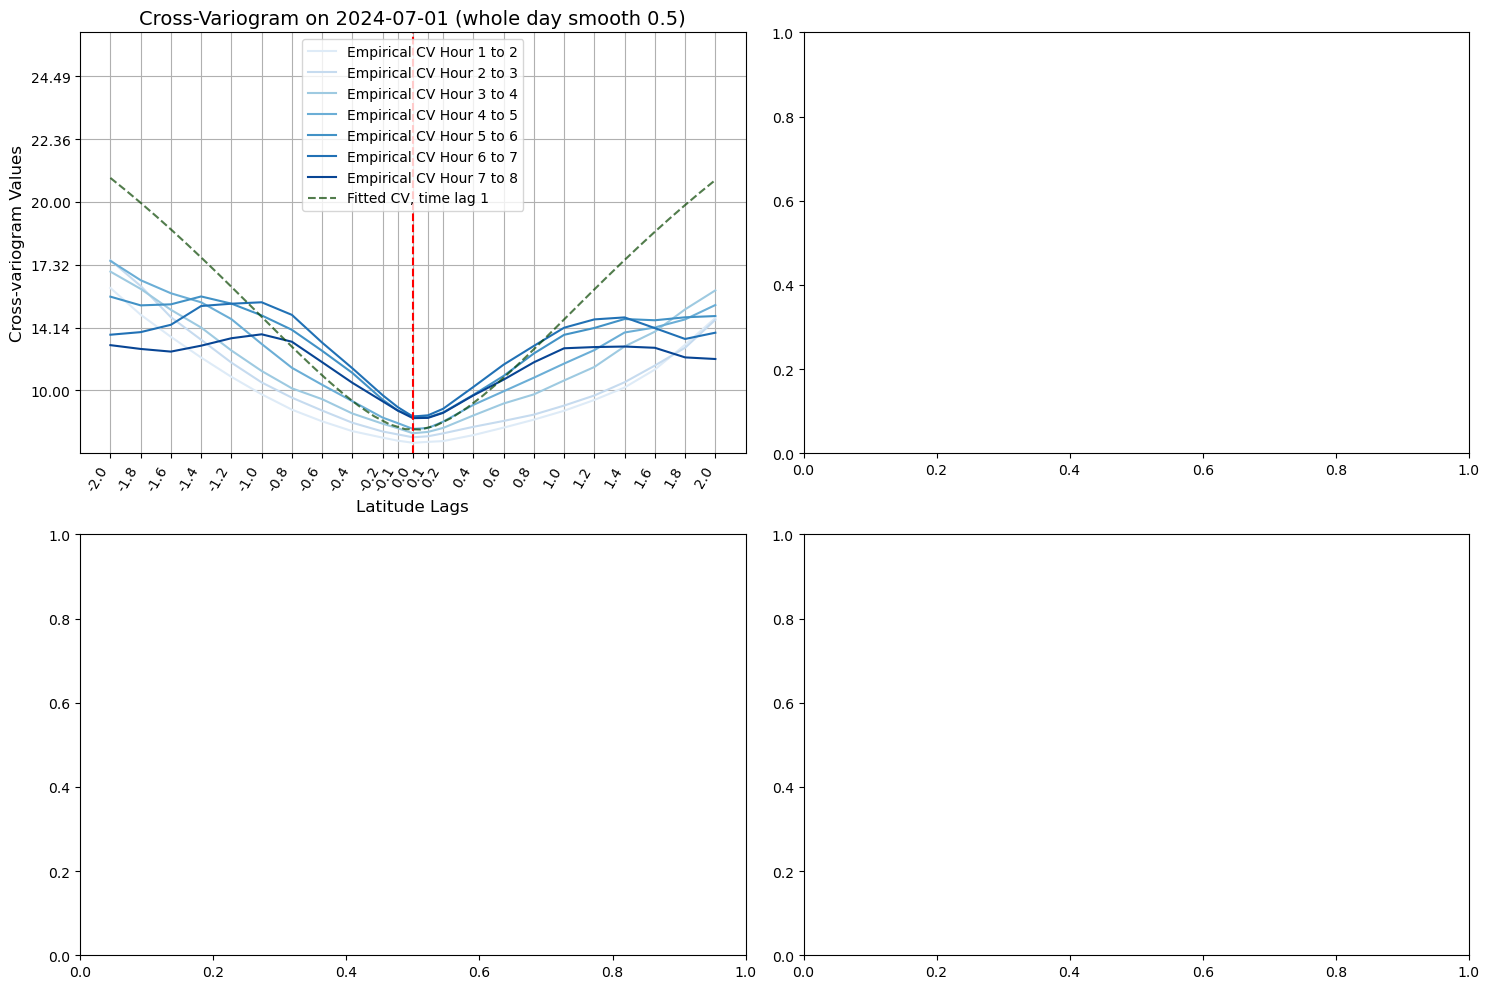

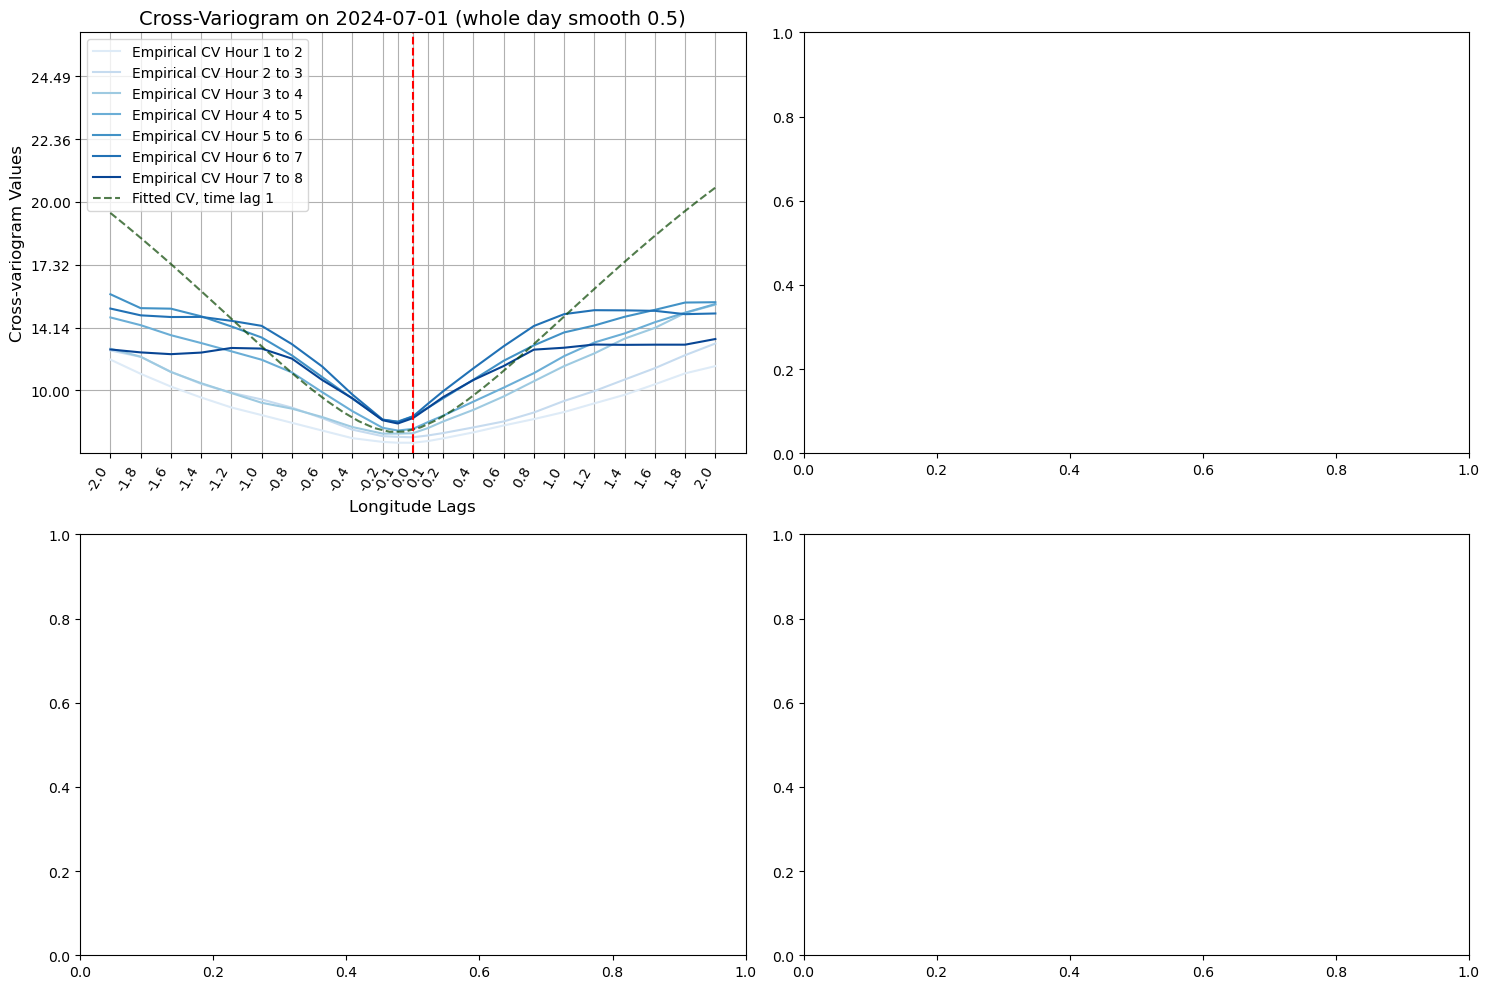

In [20]:
save_path = config.mac_save_semivariogram_path
smooth = 0.5
length_of_analysis = f'whole day smooth {smooth:0.1f}'
instance_sem = evaluate.CrossVariogram_emp_theory(save_path, length_of_analysis,smooth)

input_filename = "full_day_v05_1250.0.csv"
input_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/Exercises/st_model/estimates"
input_filepath = os.path.join(input_path, input_filename)
df_full_v05 = pd.read_csv(input_filepath)
df_full_v05 = df_full_v05.iloc[:,5:13]
date_range = pd.date_range(start='07-01-24', end='07-31-24')
df_full_v05.index = date_range


# dayss = [[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [17,18,19,20], [21,22,23,24], [25,26,27,28], [29,30,31]]

dayss = [[1]]

for days in dayss:
    tmp = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))
    tolerance = 0.02

    # latitude direction
    lat_lags = [ (round(a,1),0 ) for a in tmp]
    instance_sem.plot_lat_emp_the( d_lat_20000,days, lat_lags, df_full_v05, instance_sem.theoretical_gamma_kv)

    # longitude direction
    lon_lags = [ (0, round(a,1)) for a in tmp]
    instance_sem.plot_lon_emp_the( d_lon_20000,days,lon_lags, df_full_v05, instance_sem.theoretical_gamma_kv)



# smooth 1.0

In [24]:
save_path = config.mac_save_semivariogram_path
smooth = 1.0
length_of_analysis = f'whole day smooth {smooth:0.1f}'
instance_sem = evaluate.CrossVariogram_emp_theory(save_path, length_of_analysis,smooth)

input_filename = "full_day_v10_spline1250.0.csv"
input_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/Exercises/st_model/estimates"
input_filepath = os.path.join(input_path, input_filename)
df_full_v10 = pd.read_csv(input_filepath)  
df_full_v10 = df_full_v10.iloc[:,5:13]  

date_range = pd.date_range(start='07-01-24', end='07-31-24')
df_full_v10.index = date_range

df_full_v10


,sigma,range_lat,range_lon,advec_lat,advec_lon,beta,nugget,loss
2024-07-01,26.142,0.790,0.853,0.004,-0.114,0.269,4.337,14124.554
2024-07-02,25.707,0.824,0.796,0.041,-0.075,0.334,2.572,12421.396
2024-07-03,25.801,0.388,0.488,0.028,-0.155,0.591,2.681,15137.174
2024-07-04,26.611,0.597,0.668,-0.150,-0.207,0.301,4.116,14847.308
2024-07-05,25.310,1.106,1.380,-0.022,-0.156,0.205,3.086,12140.580
2024-07-06,24.654,0.687,1.181,0.015,-0.173,0.243,4.050,14884.526
2024-07-07,27.006,0.473,1.090,0.055,-0.339,0.268,5.153,15401.798
2024-07-08,27.742,0.530,0.902,-0.018,-0.406,0.304,4.995,14936.513
2024-07-09,26.573,0.588,1.027,0.023,-0.219,0.336,2.715,12724.811
2024-07-10,25.415,0.368,0.546,0.035,-0.104,0.526,2.942,15243.307


In [ ]:
dayss = [[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [17,18,19,20], [21,22,23,24], [25,26,27,28], [29,30,31]]

for days in dayss:
    tmp = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))
    tolerance = 0.02

    # latitude direction
    lat_lags = [ (round(a,1),0 ) for a in tmp]
    instance_sem.plot_lat_emp_the( d_lat_20000,days, lat_lags, df_full_v10, instance_sem.theoretical_gamma_kv)
 
    # longitude direction
    lon_lags = [ (0, round(a,1)) for a in tmp]
    instance_sem.plot_lon_emp_the( d_lon_20000,days,lon_lags, df_full_v10,  instance_sem.theoretical_gamma_kv)



# smooth 1.5 

# empirical semivariogram and variances

This can help decide which model has better estimates of nuggets. If the estimated nuggets are too off from the extrapolation of first three shortest lag semiovariograms, then that might be the sign of model misspecification. 

In [ ]:
day = 1
hour = 0
days = [13,1,4,18]

days = list(range(1,31))
for day in days:
    lat_lon_resolution = [5,5]
    mm_cond_number = 20

    # input_path = Path("C:\\Users\\joonw\\tco\\Extracted_data")  # window
    input_path = Path("/Users/joonwonlee/Documents/GEMS_DATA")
    instance = load_data(input_path)

    years = ['2024']
    month_range =[7,8]
    idx_for_datamap= [ 8*(day-1),8*day]

    map, ord_mm, nns_map= instance.load_mm20k_data_bymonthyear( lat_lon_resolution= lat_lon_resolution, mm_cond_number=mm_cond_number,years_=years, months_=month_range)
    analysis_data_map, aggregated_data = instance.load_working_data_byday( map, ord_mm, nns_map, idx_for_datamap= idx_for_datamap)

    keys = list(analysis_data_map.keys())
 
    # print(f' The variance of ozone on day {day}, hour {hour+1}: {torch.var(analysis_data_map[keys[hour]][:,2])}')
    # print(f' The averaged variance of ozone on day {day}, : {torch.var(aggregated_data[:,2])}')

    print(f'Sorted semivariograms on day {day}, hour {hour+1} : {sorted(d_lon_20000[day][hour])}')

Sorted semivariograms on day 1, hour 1 : [4.0843621475564476, 4.089202195326694, 4.244931547769723, 4.400917412875979, 4.865506938018834, 4.894175685444802, 5.760709369936842, 6.009129730269457, 6.645473011231173, 6.957396591166211, 7.370575953849116, 7.790808191734402, 8.097251222105728, 8.533923374417741, 8.910295320153814, 9.419393965546405, 9.641524314726416, 10.30049997186139, 10.474056810965516, 11.244253928022014, 11.274948495226003, 11.77578011537965, 12.208212117490907]
Sorted semivariograms on day 2, hour 1 : [2.87711047642084, 2.8898572898175137, 3.0127361615219463, 3.195680388856138, 3.3014717242861624, 3.8218066442412155, 3.963446247414107, 4.409734652806927, 4.596392875339649, 4.805977902884793, 5.155774580009712, 5.194065635327841, 5.297340077985921, 5.313499317418687, 5.318254743149323, 5.3222651529237925, 5.557435082598439, 5.5906308482397415, 5.6982166190438575, 5.7230112092166925, 5.827156200843095, 5.9940808006471915, 6.052390412169415]
Sorted semivariograms on day 

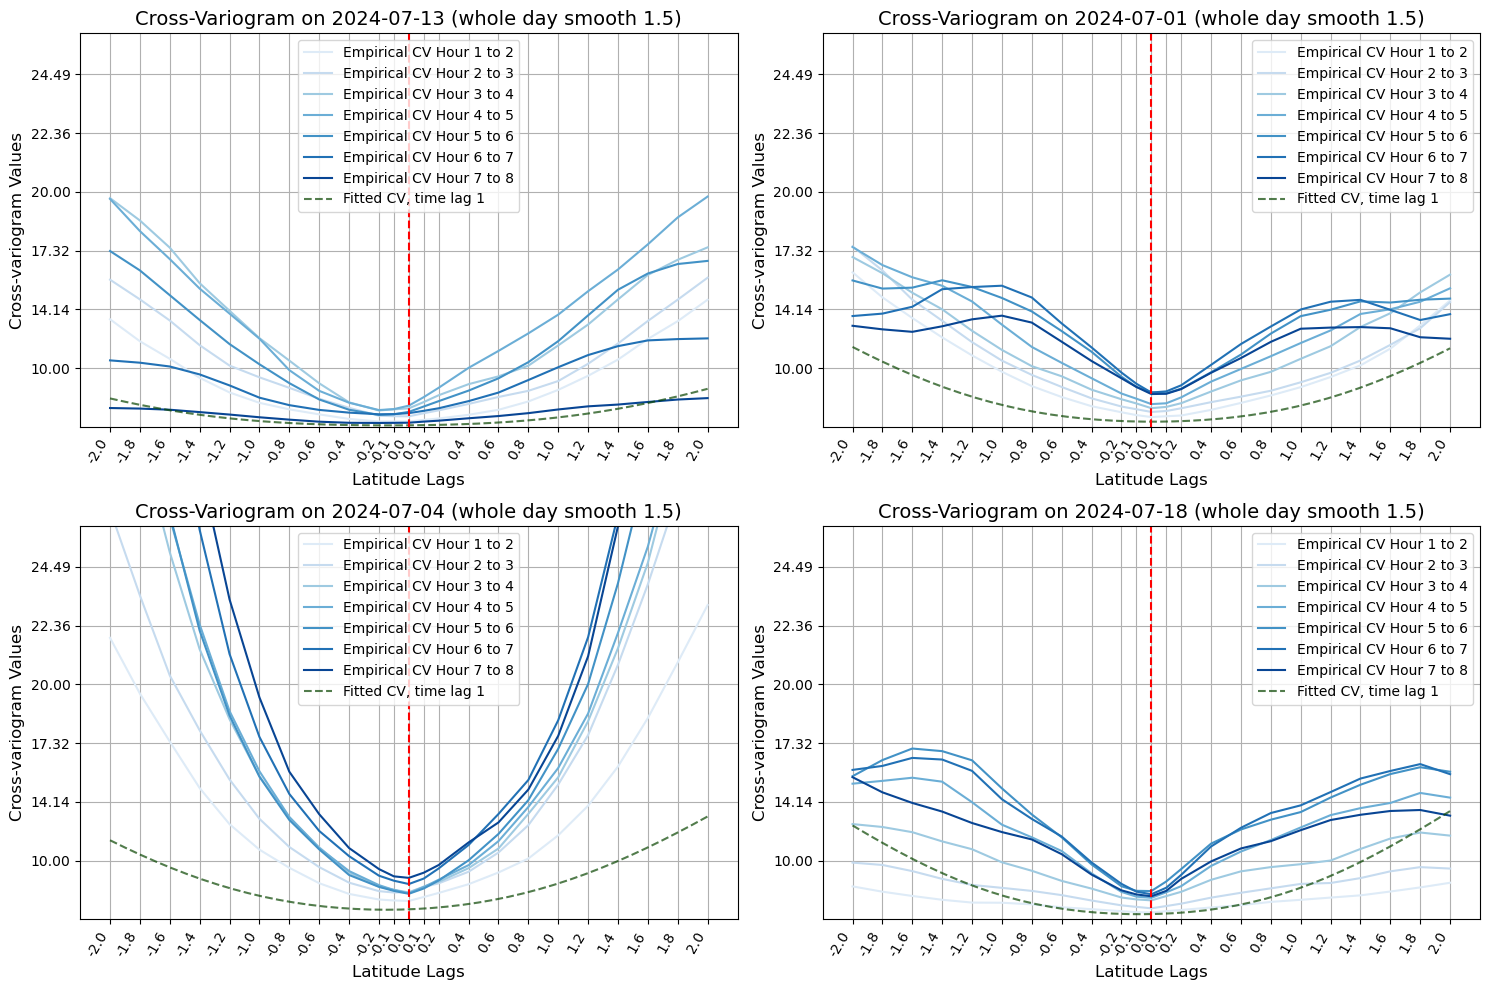

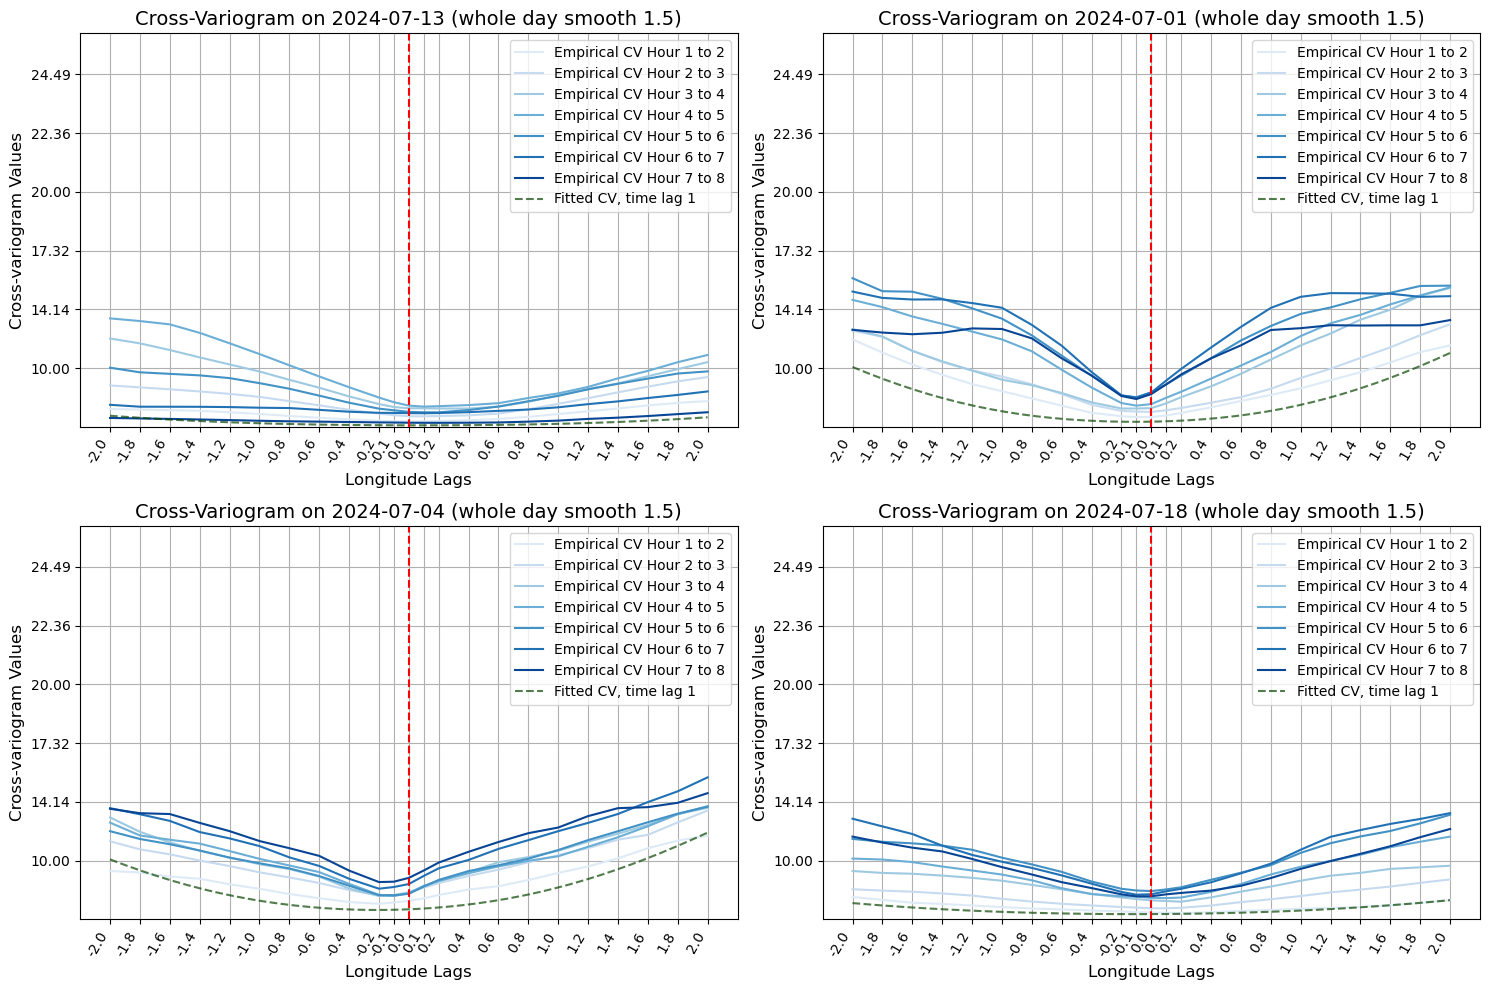

In [28]:
save_path = config.mac_save_semivariogram_path
smooth = 1.5
length_of_analysis = f'whole day smooth {smooth:0.1f}'
instance_sem = evaluate.CrossVariogram_emp_theory(save_path, length_of_analysis,smooth)

input_filename = "full_v15_1250.0.csv"
input_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/Exercises/st_model/estimates"
input_filepath = os.path.join(input_path, input_filename)
df_full_v15 = pd.read_csv(input_filepath)
df_full_v15 = df_full_v15.iloc[:,5:13]
date_range = pd.date_range(start='07-01-24', end='07-31-24')
df_full_v15.index = date_range

dayss = [[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [17,18,19,20], [21,22,23,24], [25,26,27,28], [29,30,31]]

dayss = [[13,1,4,18]]

for days in dayss:

    tmp = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))
    tolerance = 0.02

    # latitude direction
    lat_lags = [ (round(a,1),0 ) for a in tmp]
    instance_sem.plot_lat_emp_the( d_lat_20000,days, lat_lags, df_full_v05, instance_sem.theoretical_gamma_kv)

    # longitude direction
    lon_lags = [ (0, round(a,1)) for a in tmp]
    instance_sem.plot_lon_emp_the( d_lon_20000,days,lon_lags, df_full_v05, instance_sem.theoretical_gamma_kv)


# Empirical cross variograms without theoretical counterparts.

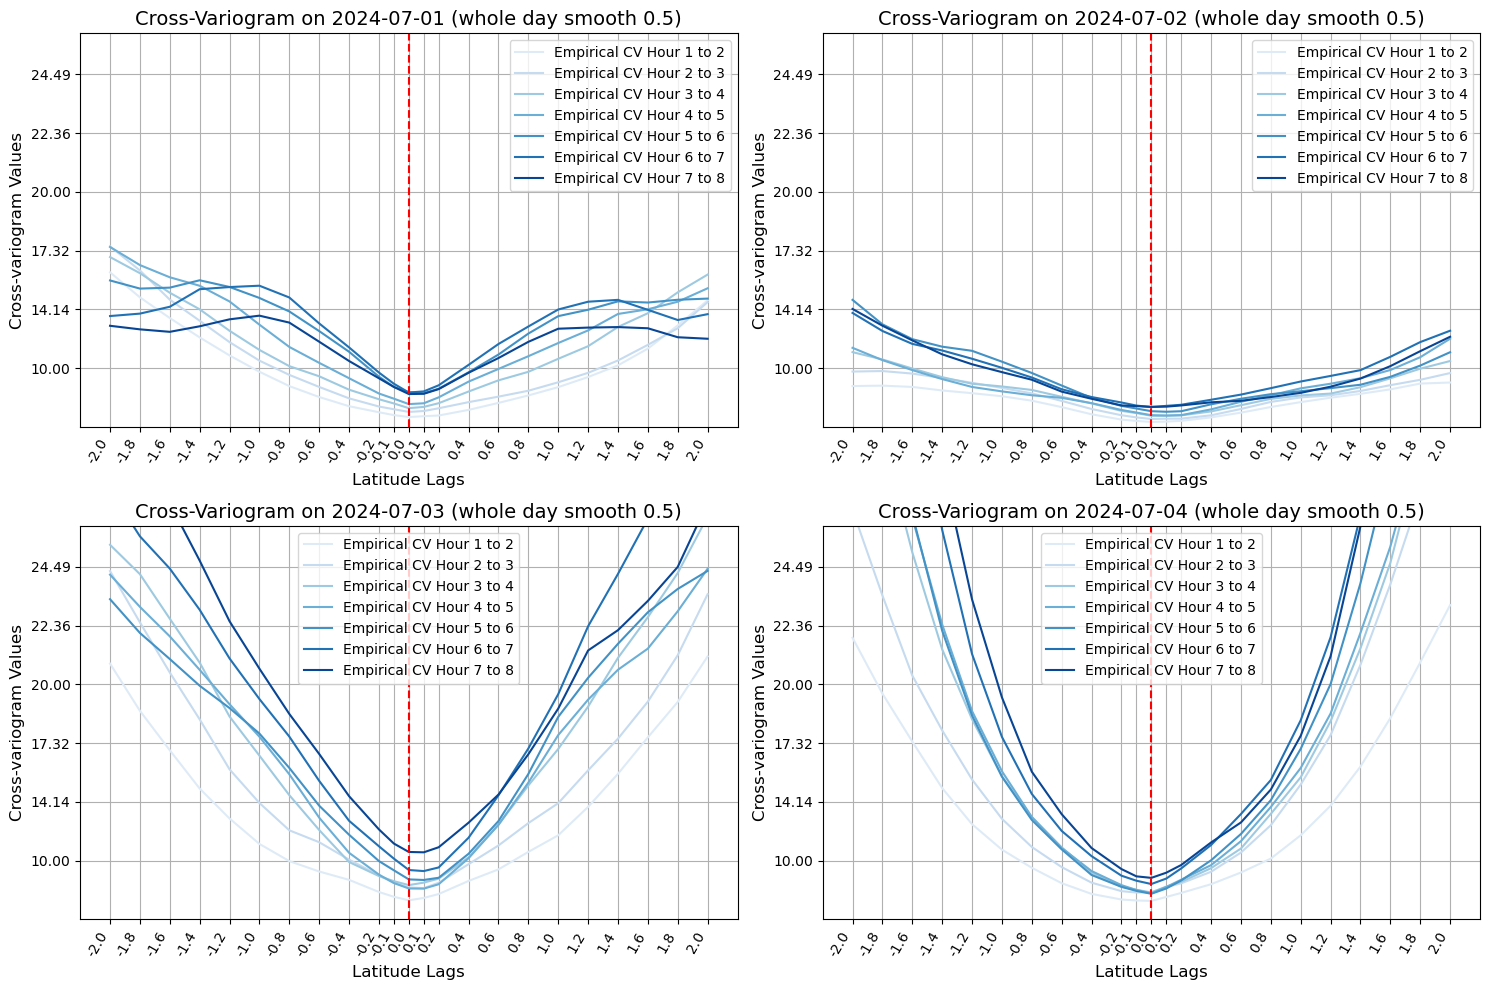

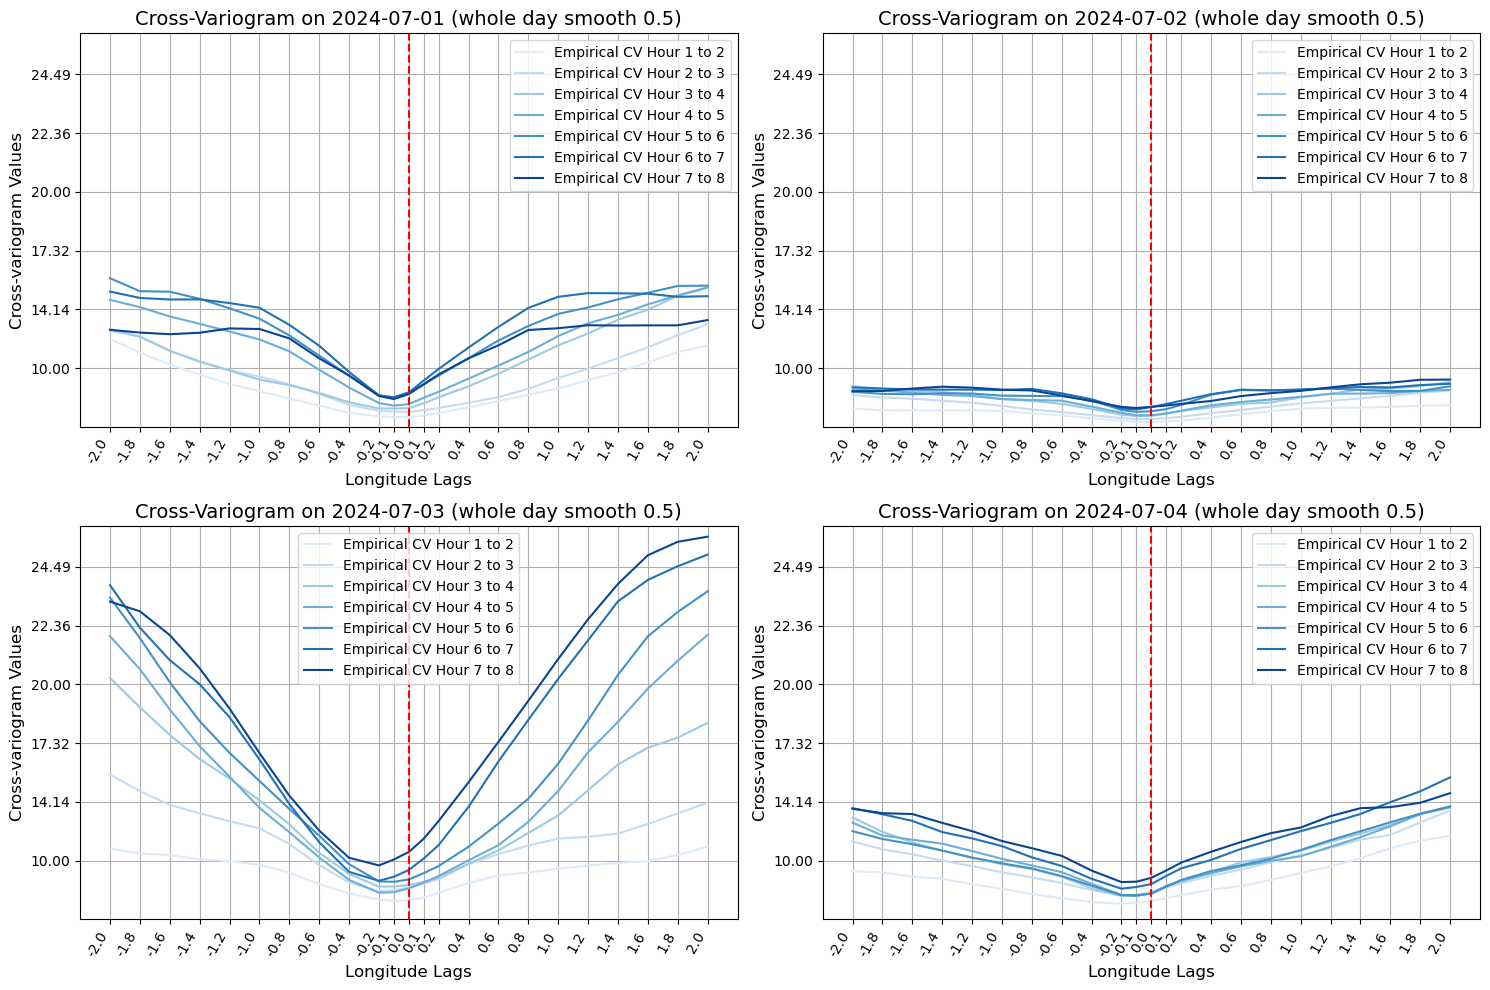

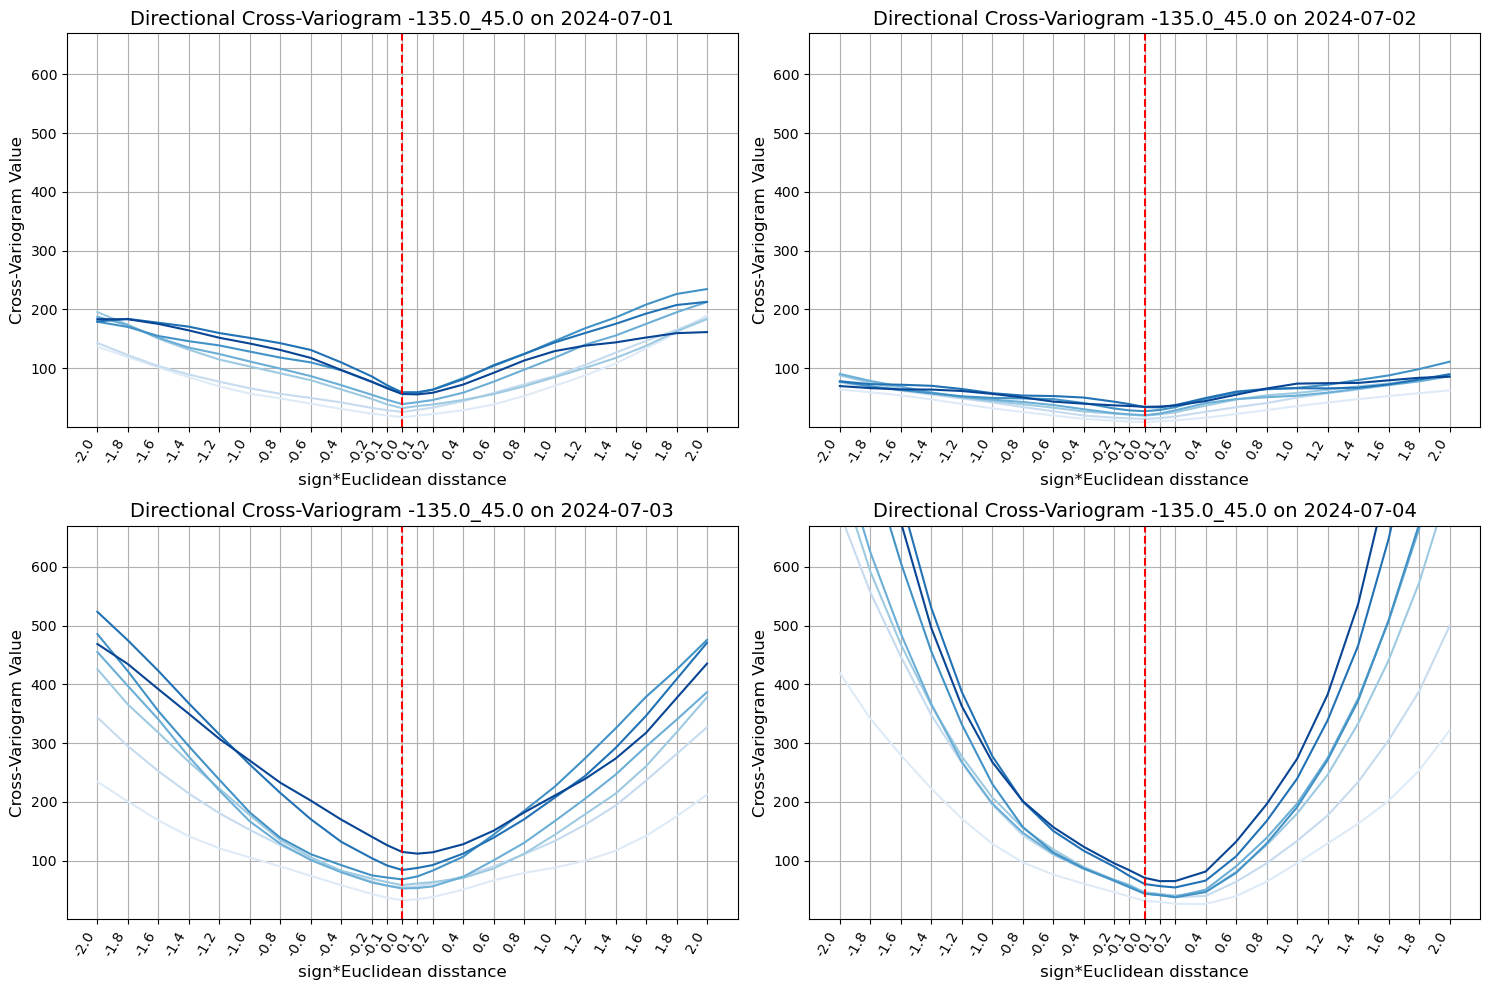

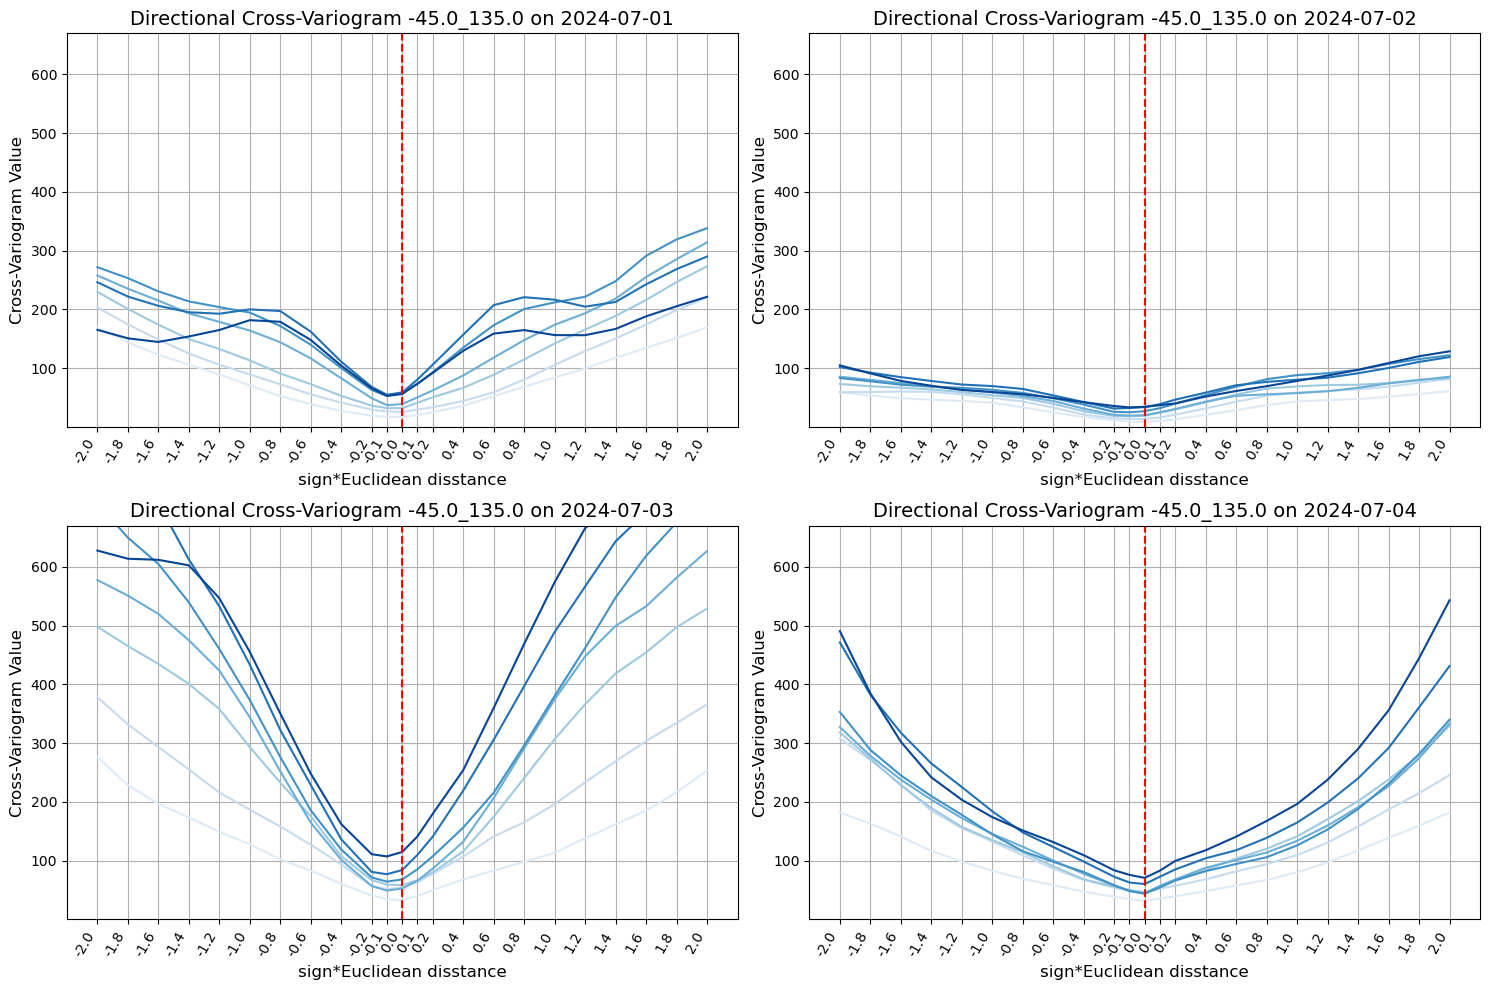

In [4]:
save_path = config.mac_save_semivariogram_path
smooth = 0.5
length_of_analysis = f'whole day smooth {smooth:0.1f}'
instance_sem = evaluate.CrossVariogram_empirical(save_path, length_of_analysis,smooth)


# x_values = [-1, -.8, -.6, -.4, -.2, 0, 0.2, 0.4, 0.6, 0.8, 1]
dayss = [[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [17,18,19,20], [21,22,23,24], [25,26,27,28], [29,30,31]]
tmp = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))
dayss = [[1,2,3,4]]
for days in dayss:
    
    tolerance = 0.02

    # latitude direction
    lat_lags = [ (round(a,1),0 ) for a in tmp]
    instance_sem.plot_lat_empirical( d_lat_20000,days, lat_lags)

    # longitude direction
    lon_lags = [ (0, round(a,1)) for a in tmp]
    instance_sem.plot_lon_empirical( d_lon_20000,days,lon_lags)

    tolerance = 0.02
    d45 = np.arctan2(1,1)
    d135 = np.arctan2(-1,-1)  

    # y=x direction
    instance_sem.plot_directional_sem_empirical(tmp, d135_45_20000, days, d135, d45)

    # y=-x direction
    dn45 = np.arctan2(-1,1)
    dn135 = np.arctan2(1,-1)
    instance_sem.plot_directional_sem_empirical(tmp, dn45_n135_20000, days, dn45, dn135)


### which hours are important?

In [ ]:
ssdf = d_lon_20000
res = [] 

for j in range(1, len(ssdf)):
    tmp = []
    sdf = d_lon_20000[j]
    for i in range(len(sdf)-1):
        # print(f'correlation between {i} and {i+1} in day {j} {np.corrcoef( sdf[i], sdf[i+1])}' )
        tmp.append( np.corrcoef( sdf[i], sdf[i+1])[0][1] )
    min_correlation_index = np.argmax(tmp)
    res.append(min_correlation_index)


plt.hist(res, bins=range(min(res), max(res) + 2), edgecolor='black', align='left')
plt.xlabel('Index of Maximum Correlation')
plt.ylabel('Frequency')
plt.title('Histogram of Index of Maximum Correlation')
plt.xticks(range(min(res), max(res) + 1))
plt.show()